In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import numpy as np
import viper_detector
from scipy.ndimage import gaussian_filter
import time
from utils import *
import copy
import hcipy
import os.path
import csv
from astropy.io import fits
from processing import *
import time
from Keck_aperture import *

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

# Initial Setup

Telecope Setup

In [2]:
telescope_diameter = 10.9 #m, circumscribed diameter
collecting_area = 76 #m^2, Source: https://en.wikipedia.org/wiki/W._M._Keck_Observatory

HCIpy Grid Setup

In [3]:
num_pupil_pixels = 200 #Number of pixels in your pupil
pupil_oversize_factor = 1.2
pupil_grid_diameter = pupil_oversize_factor * telescope_diameter #m, the physical size of the pupil. Let's oversize it a bit to have extra padding
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

#Super sample the Keck Aperture (how much is enough?)
telescope_aperture = evaluate_supersampled(keck_aperture, pupil_grid, 12)

#The grid for the pyramid WFS. The Keck Pywfs has 40 pixels across the pupil, we'll oversize the grid a bit. 
pwfs_grid = make_pupil_grid(int(80*pupil_oversize_factor), 2 * pupil_grid_diameter)

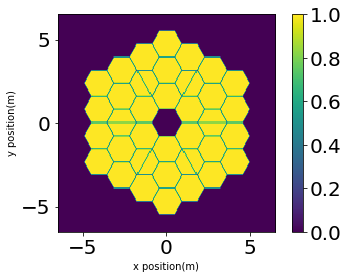

In [4]:
imshow_field(telescope_aperture)
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()

Source and Observing Setup

In [5]:
filter_name = 'R' # Name of filter. Not applicable for IR detectors
mag = 10 # Magnitude in the band of interest

wfs_filter_name = 'H' #The WFS filter
wfs_mag = 10

wavelength_wfs = filters[wfs_filter_name]['lambda_eff']*1e-6 #m, the wavelength at which you're wavefront sensing
wavelength=filters[filter_name]['lambda_eff']*1e-6 #m, the wavelength at your final detector
k=2*np.pi/wavelength

AO Parameters

In [6]:
#leaky integrator parameters - Based on Maaike's SPIE paper. 
gain = 0.4
leakage = 0.999
#AO loop speed:
ao_loop_speed = 1000 #Hz
dt = 1./ao_loop_speed #AO Time Step = 1/ao_loop_speed
dt = 1.7e-3 #

actuator_spacing = 562.5e-3 #Based on this website: https://www.oir.caltech.edu/twiki_oir/bin/view/Keck/NGAO/NotesKeckPSF
num_actuators_across_pupil=telescope_diameter/actuator_spacing #Number of actuators across thepupil
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing) 
deformable_mirror = DeformableMirror(influence_functions) #The DM
num_modes = deformable_mirror.num_actuators #The number of modes that the DM can correct - this equals the number of acturors

Exoposure Settings

In [7]:
micro_integration_time = dt #mirco-integration time (set this to the AO time step)
exposure_time = 0.01 # Exposure time in seconds. This will be made up of micro-integrations
exposure_total = 200 # Total number of exposures

PyWFS Setup

In [8]:
#make the pywfs
mld=5 # modulation radius in lambda/D 
modsteps=20 #Number of steps to emulate the modulating prism
modradius = mld*wavelength_wfs/telescope_diameter # modulation radius in radians;

pwfs = PyramidWavefrontSensorOptics(pupil_grid, pwfs_grid, separation=pupil_grid_diameter, 
                                    pupil_diameter=telescope_diameter, wavelength_0=wavelength_wfs, q=3)
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs,modradius,modsteps)
wfs_camera = NoiselessDetector(pwfs_grid) 

Wavefront Setup

In [9]:
#Create a wavefront for the wavefront sensor wavelength
wfs_wf = Wavefront(telescope_aperture, wavelength_wfs)
wfs_wf.total_power = number_of_photons(wfs_mag,wfs_filter_name,collecting_area,)#In photons/s

#Create a wavefront for the science wavelength
wf = Wavefront(telescope_aperture, wavelength)
wf.total_power = number_of_photons(mag,filter_name,collecting_area,)#In photons/s

# AO System Calibration

Calculate the Reference Image

Modulating PyWFS
Runtime for Modulating PyWFS = 4e+00s


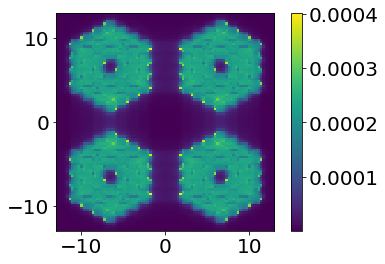

In [10]:
#commands to modulate the PyWFS, get an image out, and calculate a reference slope
print("Modulating PyWFS")
start = time.perf_counter()

#Create a temporary wavefront that is only used here with big power
wf_tmp = Wavefront(telescope_aperture, wavelength_wfs)
wf_tmp.total_power = 1e10

deformable_mirror.flatten()
for m in range (modsteps) :
    print("Percent complete = ", round((m+1)/modsteps * 100, 3), end = '\r')
    wfs_camera.integrate(mpwfs(wf_tmp)[m], 1)
stop = time.perf_counter()
print("Runtime for Modulating PyWFS = {:.1}s".format(stop - start))

image_ref = wfs_camera.read_out()
image_ref /= image_ref.sum()

imshow_field(image_ref)
plt.colorbar()
plt.show()

Create the Interaction Matrix

In [11]:
# Create the interaction matrix
probe_amp = 0.01 * wavelength_wfs
slopes = []

#Create a temporary wavefront that is only used here with big power
wf_tmp = Wavefront(telescope_aperture, wavelength_wfs)
wf_tmp.total_power = 1
# deformable_mirror.flatten()

for ind in range(num_modes):
    if ind % 10 == 0:
        print("Measure response to mode {:d} / {:d}".format(ind+1, num_modes),end="\r")
    slope = 0

    # Probe the phase response
    for s in [1, -1]:
        amp = np.zeros((num_modes,))
        amp[ind] = s * probe_amp
        deformable_mirror.actuators = amp

        dm_wf = deformable_mirror.forward(wf_tmp)
        wfs_wf_tmp = mpwfs.forward(dm_wf)

        for m in range (modsteps) :
            wfs_camera.integrate(wfs_wf_tmp[m], 1)

#         camera.integrate(wfs_wf, 1)
        image = wfs_camera.read_out()
        image /= np.sum(image)

        slope += s * (image-image_ref)/(2 * probe_amp)

    slopes.append(slope)

slopes = ModeBasis(slopes)

In [12]:
rcond = 1E-3
reconstruction_matrix = inverse_tikhonov(slopes.transformation_matrix, rcond=rcond, svd=None)

In [13]:
spatial_resolution = wavelength / telescope_diameter
focal_grid = make_focal_grid(q=2, num_airy=20, spatial_resolution=spatial_resolution)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
norm = prop(wf).power.max()

im_ref= prop.forward(wf)

Make the camera noisy now

In [14]:
wfs_camera = viper_detector.SAPHIRA(pwfs_grid) #Made by Kyle Lam with appropriate SAPHIRA parameters

# Set up the Atmosphere

In [46]:
## Setting Up the Atmosphere
seeing = 0.6
outer_scale = 50. # (meter) 
velocity = 10. # (m/s) 

# Generating the atmosphere
fried_parameter = seeing_to_fried_parameter(seeing, 500e-9) #Seeing is typically calculated at 500nm
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
tau0 = 0.314 * fried_parameter/velocity
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

# Make the primary - with an added 130nm WFE

In [47]:
try: 
    segments = evaluate_supersampled(segments, pupil_grid, 2)
except: 
    pass

primary = SegmentedDeformableMirror(segments)
primary.random(130e-9)

RMS = 203.68523295823675


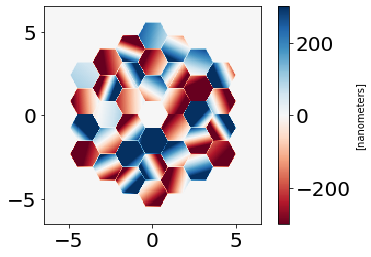

In [48]:
imshow_field(primary.opd/1e-9,cmap='RdBu',vmin=-300,vmax=300)
print("RMS = {}".format(np.mean(np.sqrt(primary.opd[np.where(np.array(telescope_aperture))]**2))/1e-9))
plt.colorbar(label="[nanometers]")

# Run the Loop

/Users/maxwellmb/Dropbox (Personal)/Library/Python/hcipy/hcipy/plotting/animation.py:119: RuntimeWarning: Something went wrong while closing the GifWriter...
  warnings.warn('Something went wrong while closing the GifWriter...', RuntimeWarning)


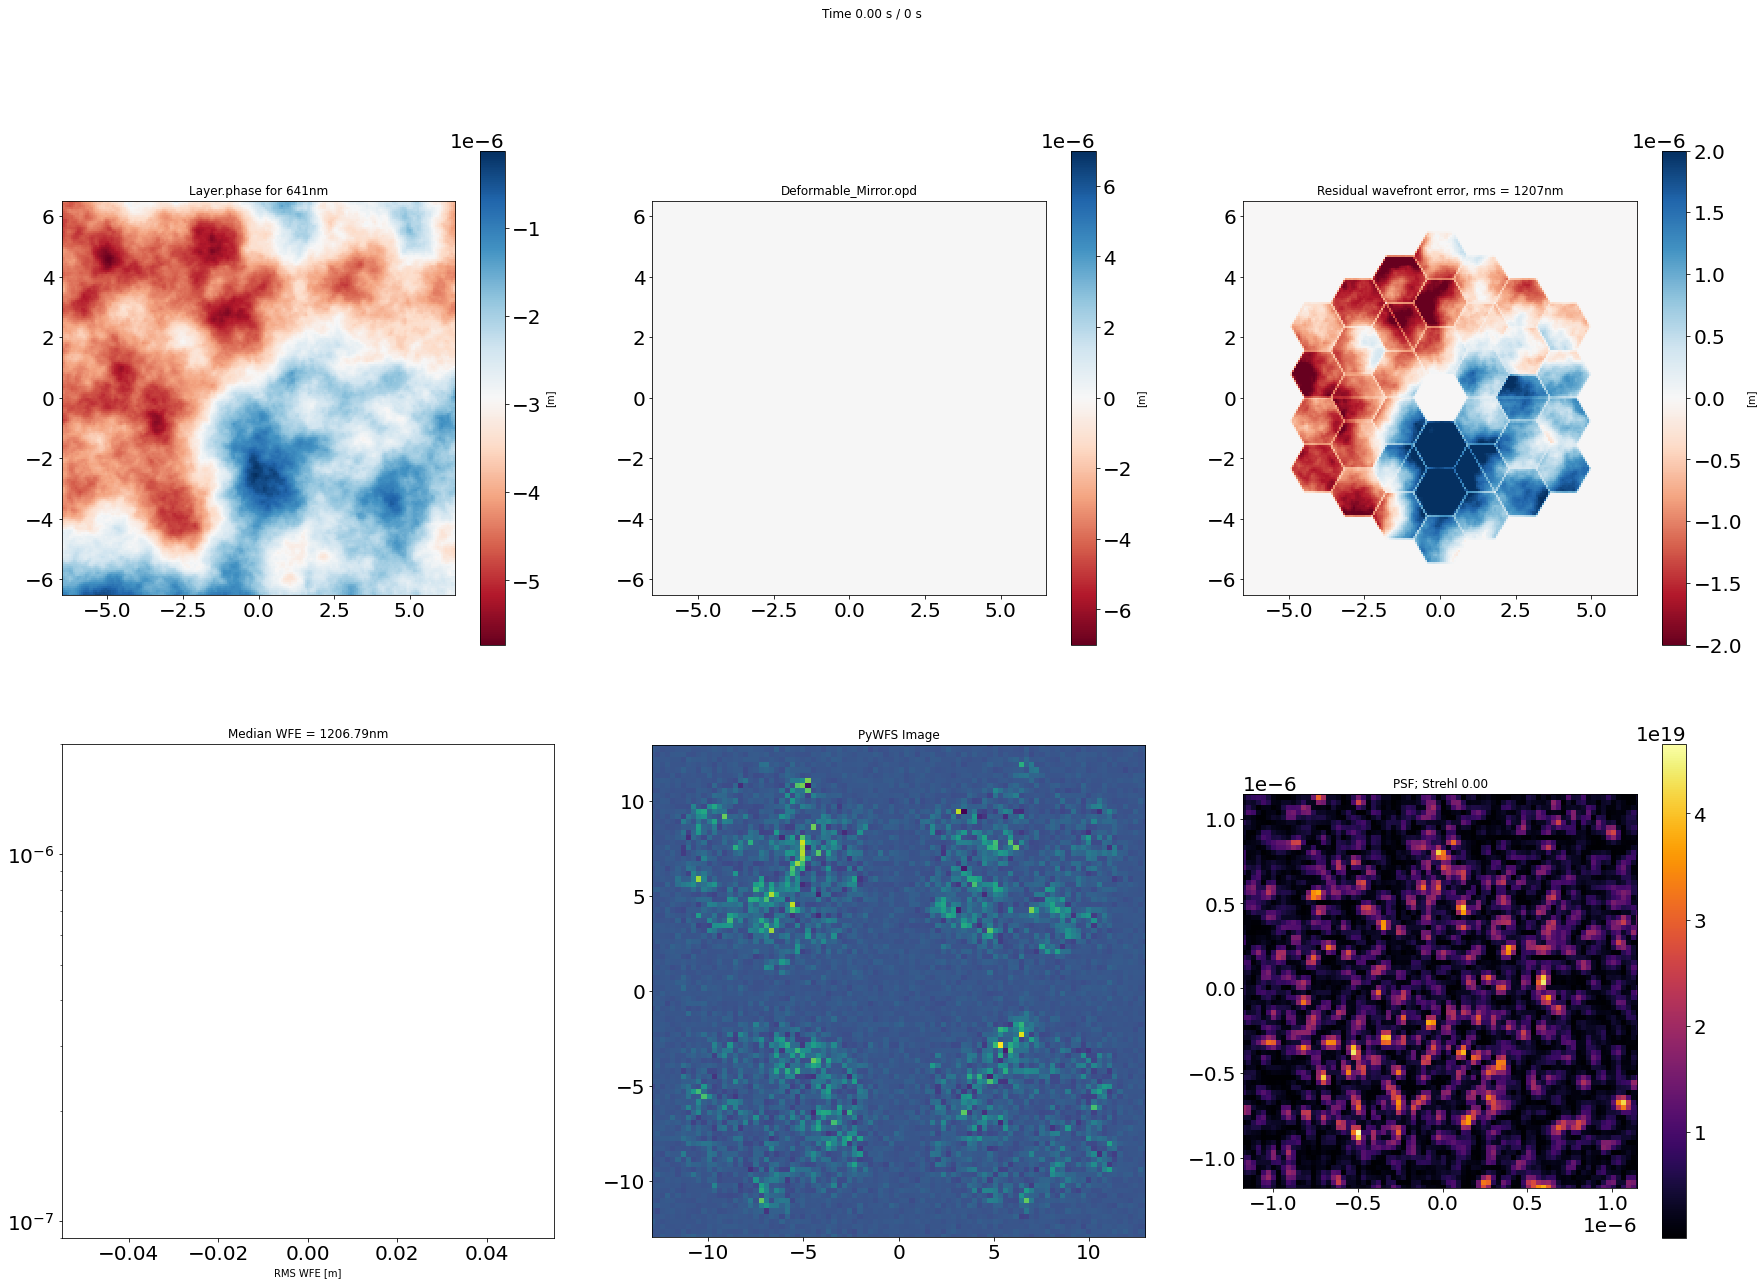

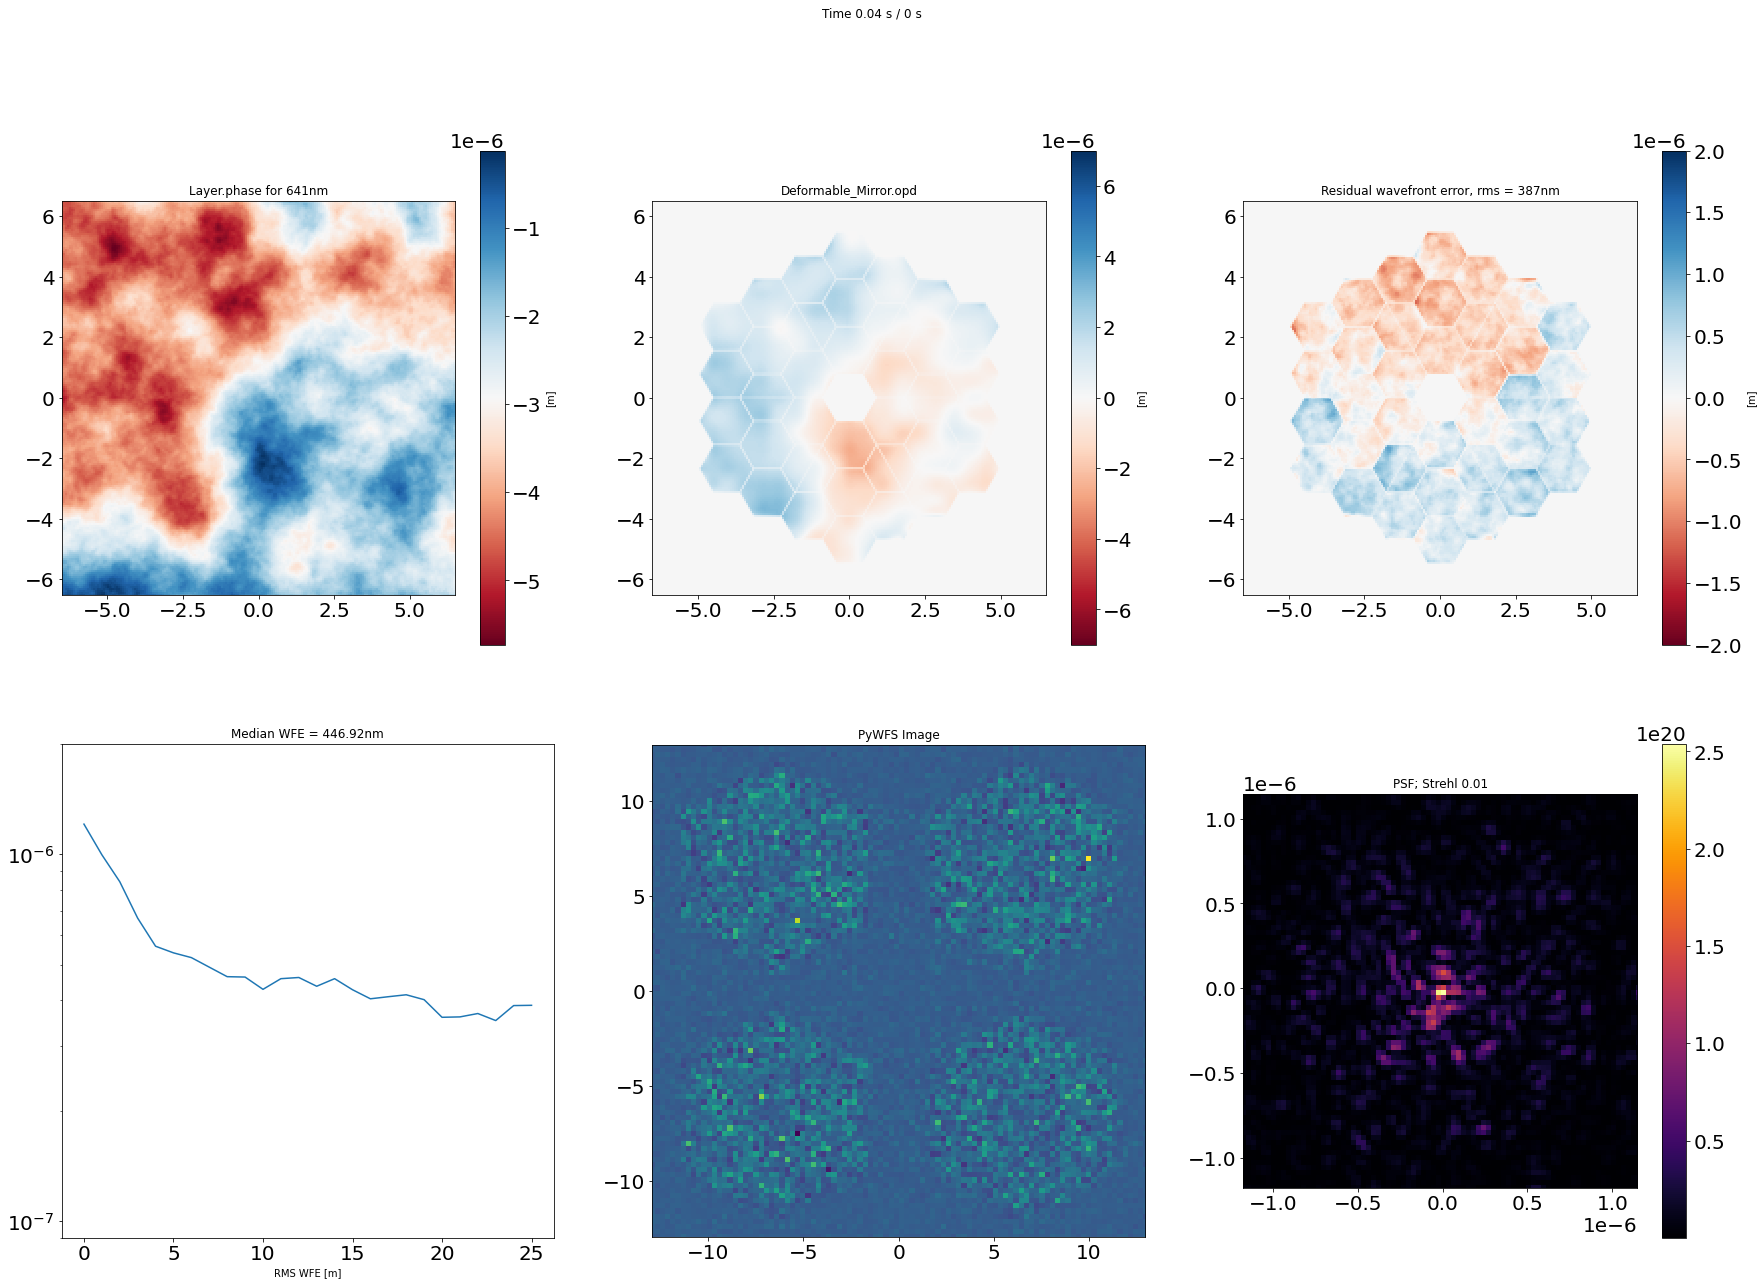

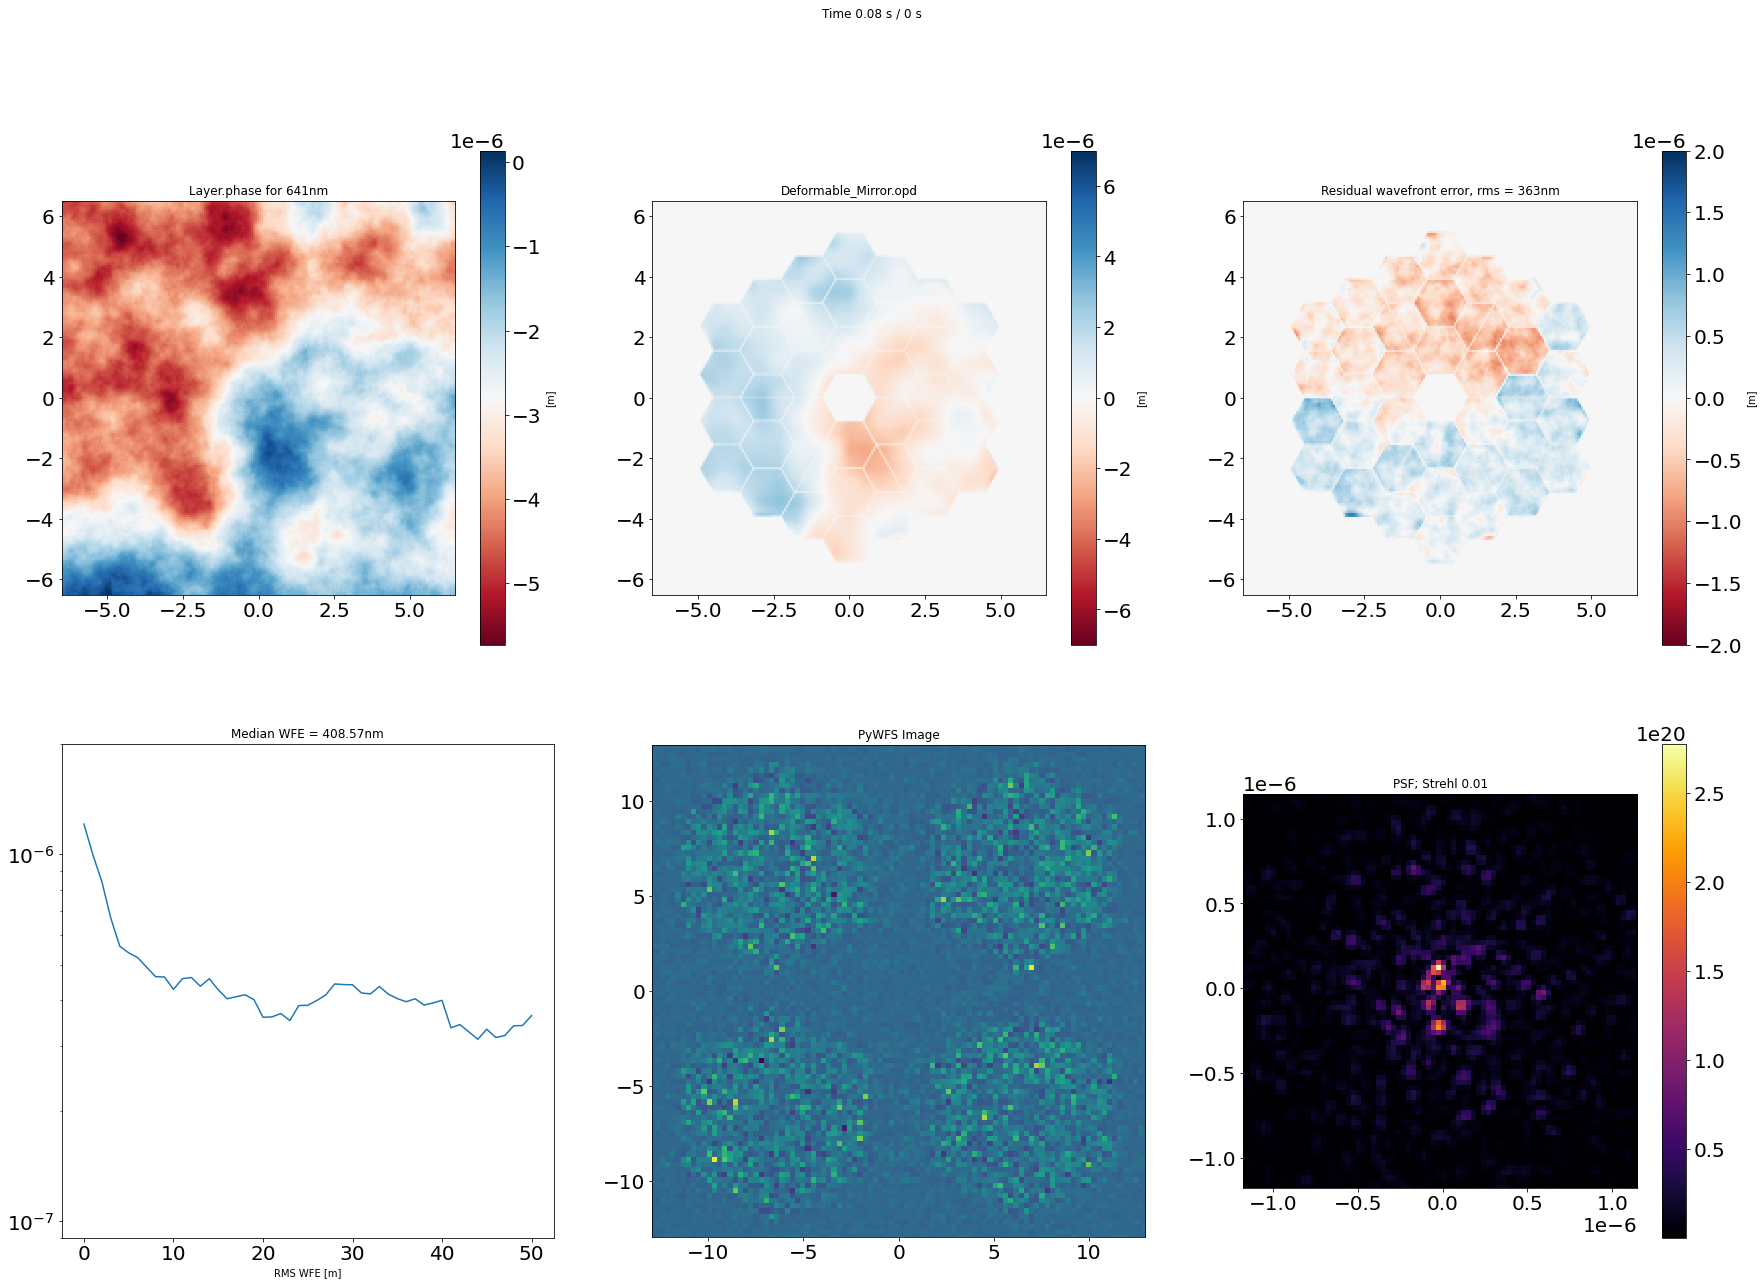

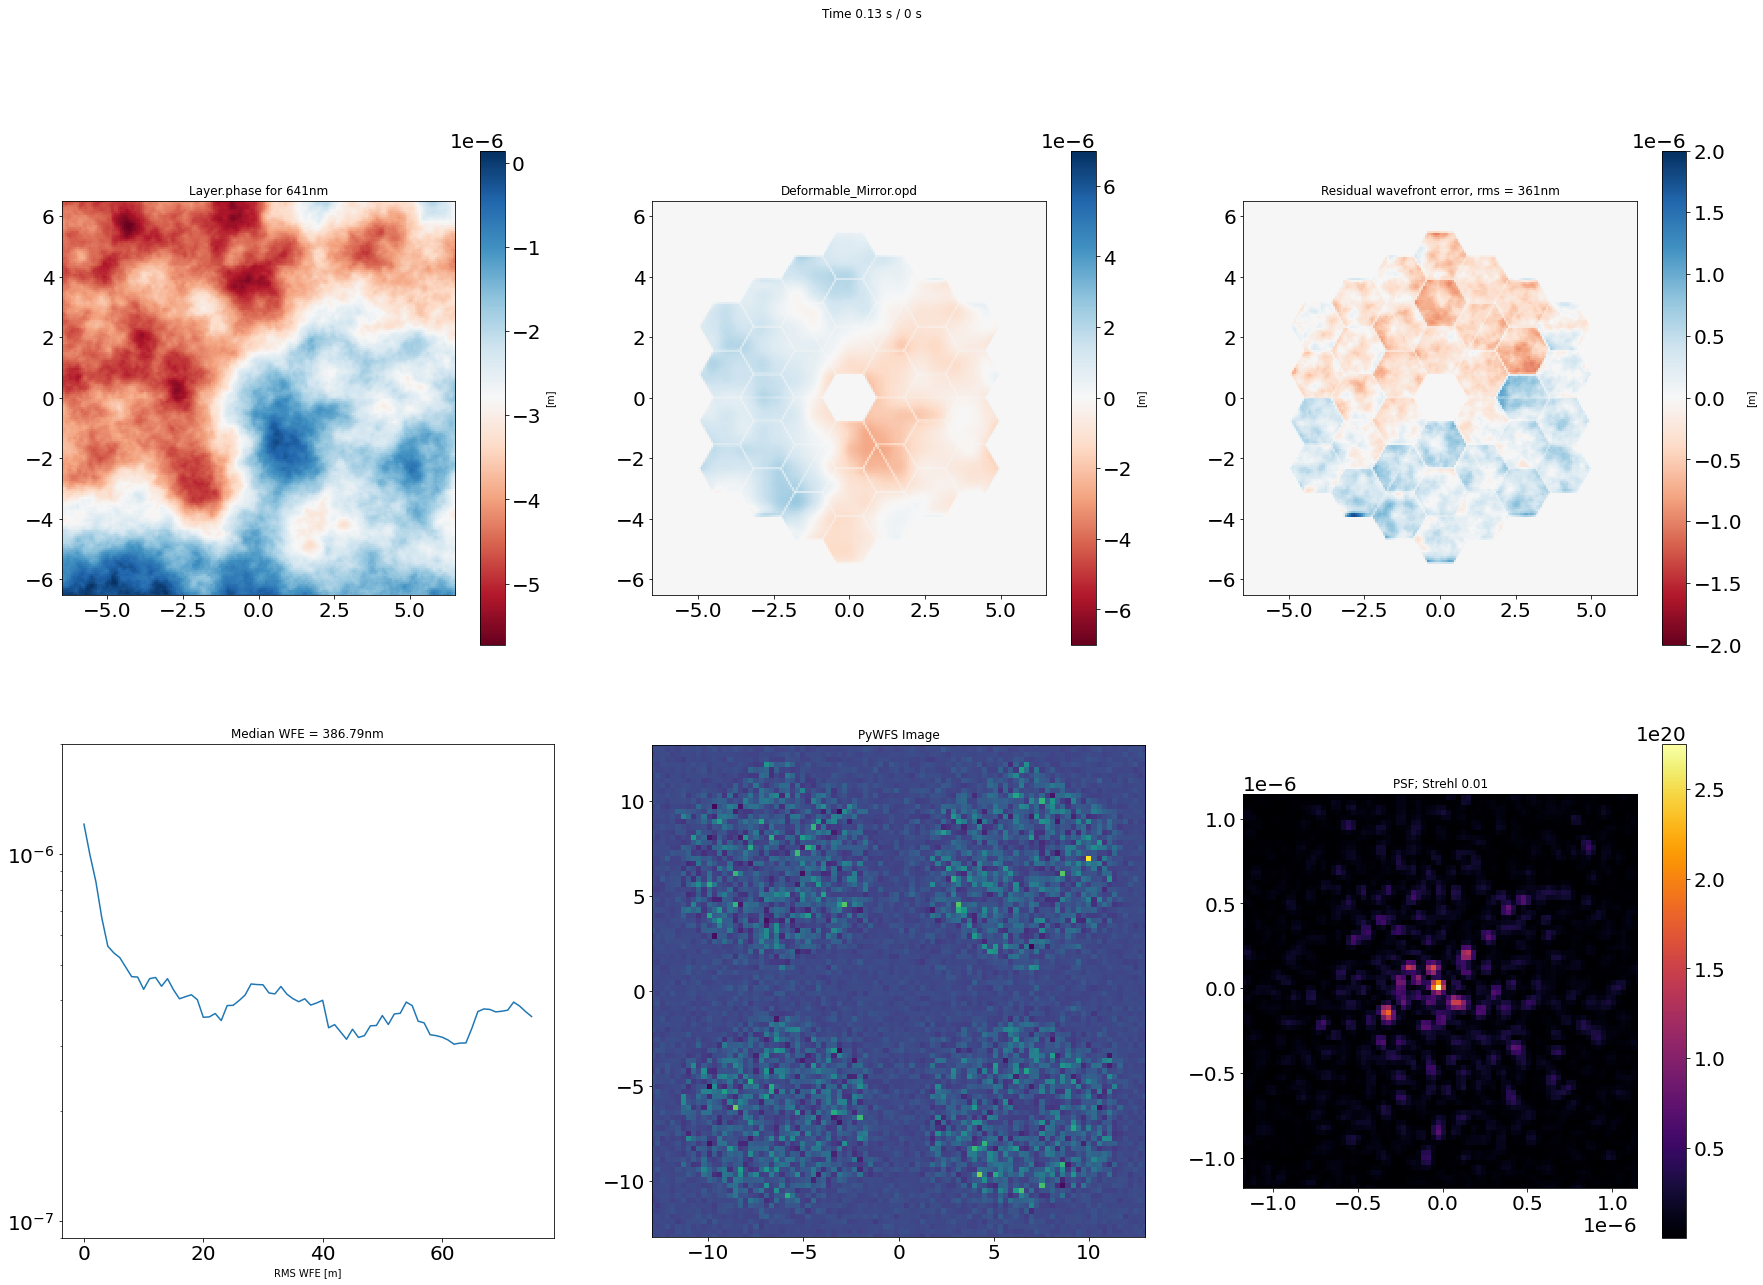

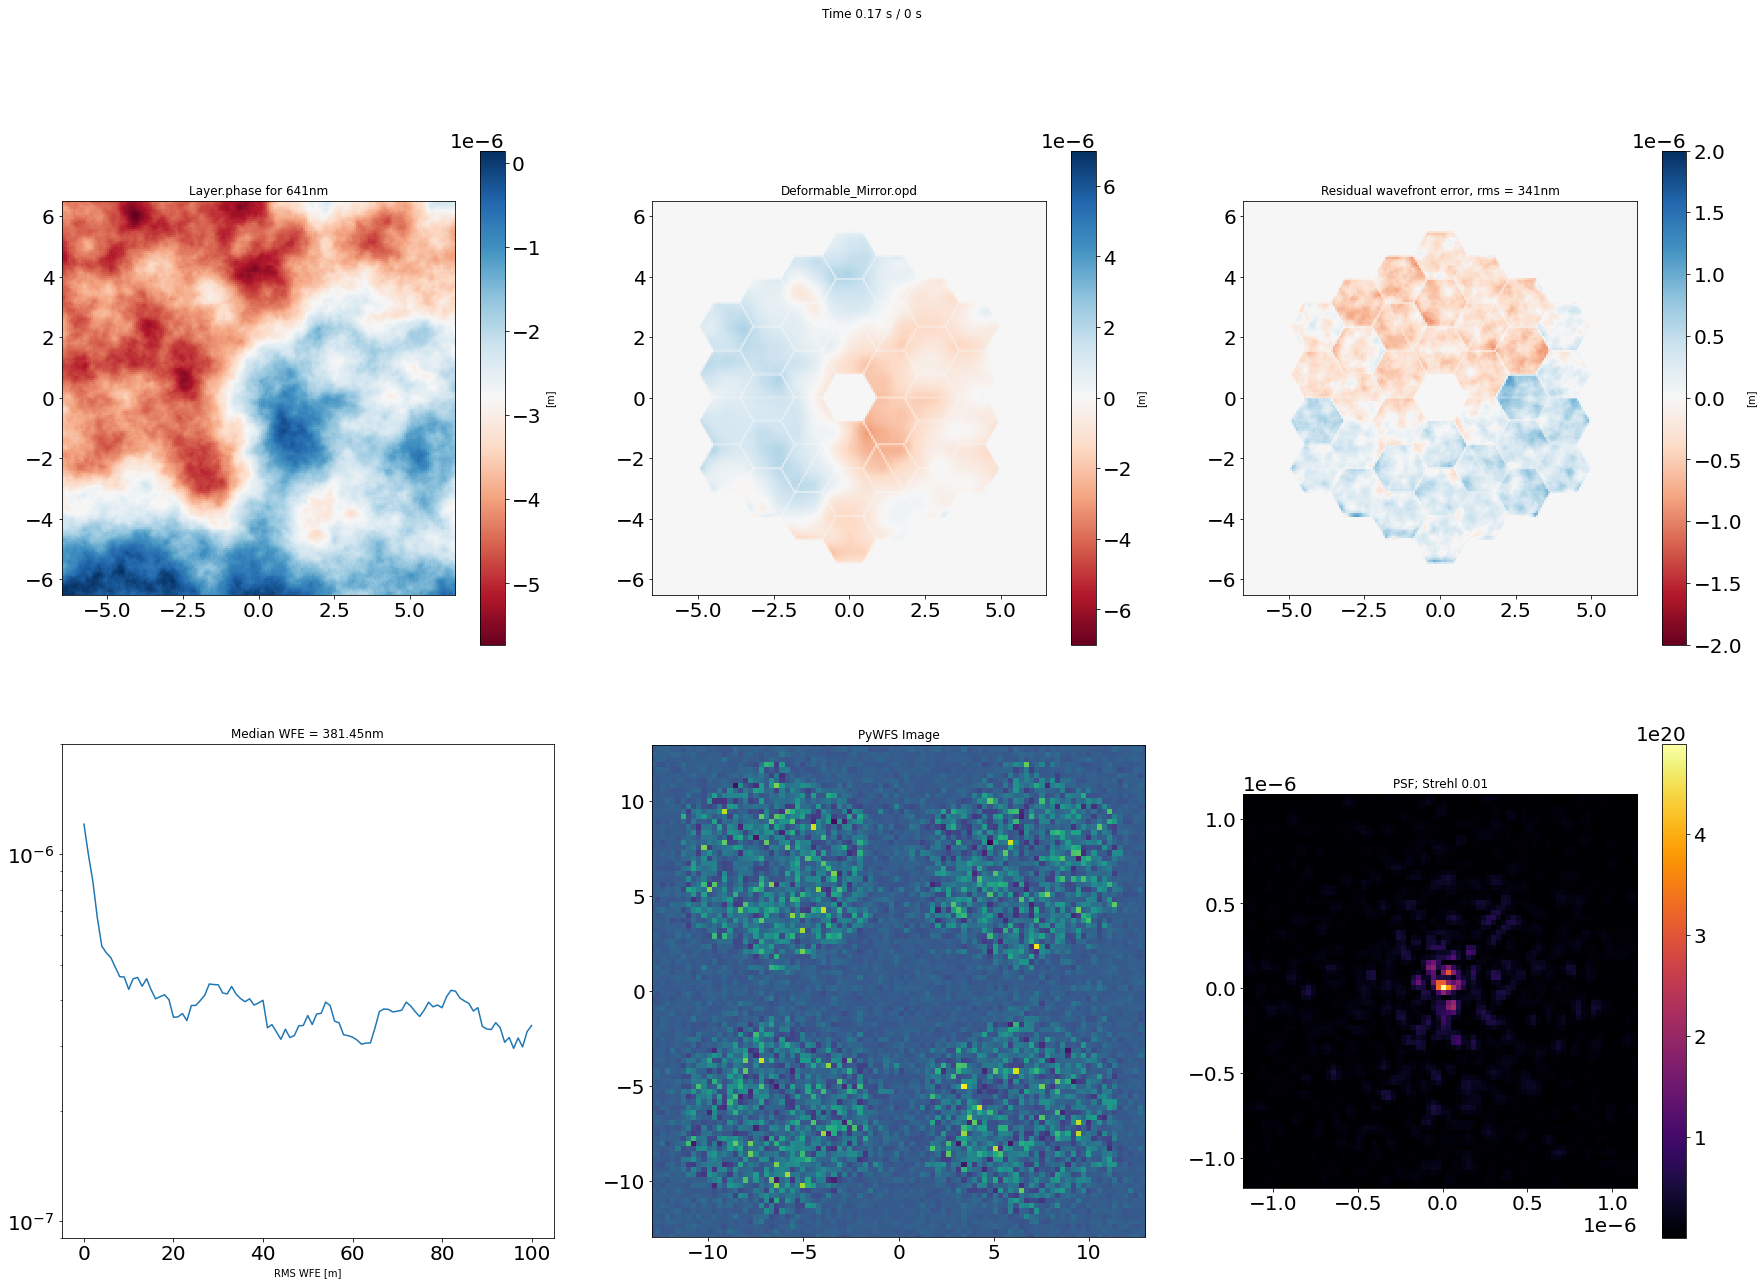

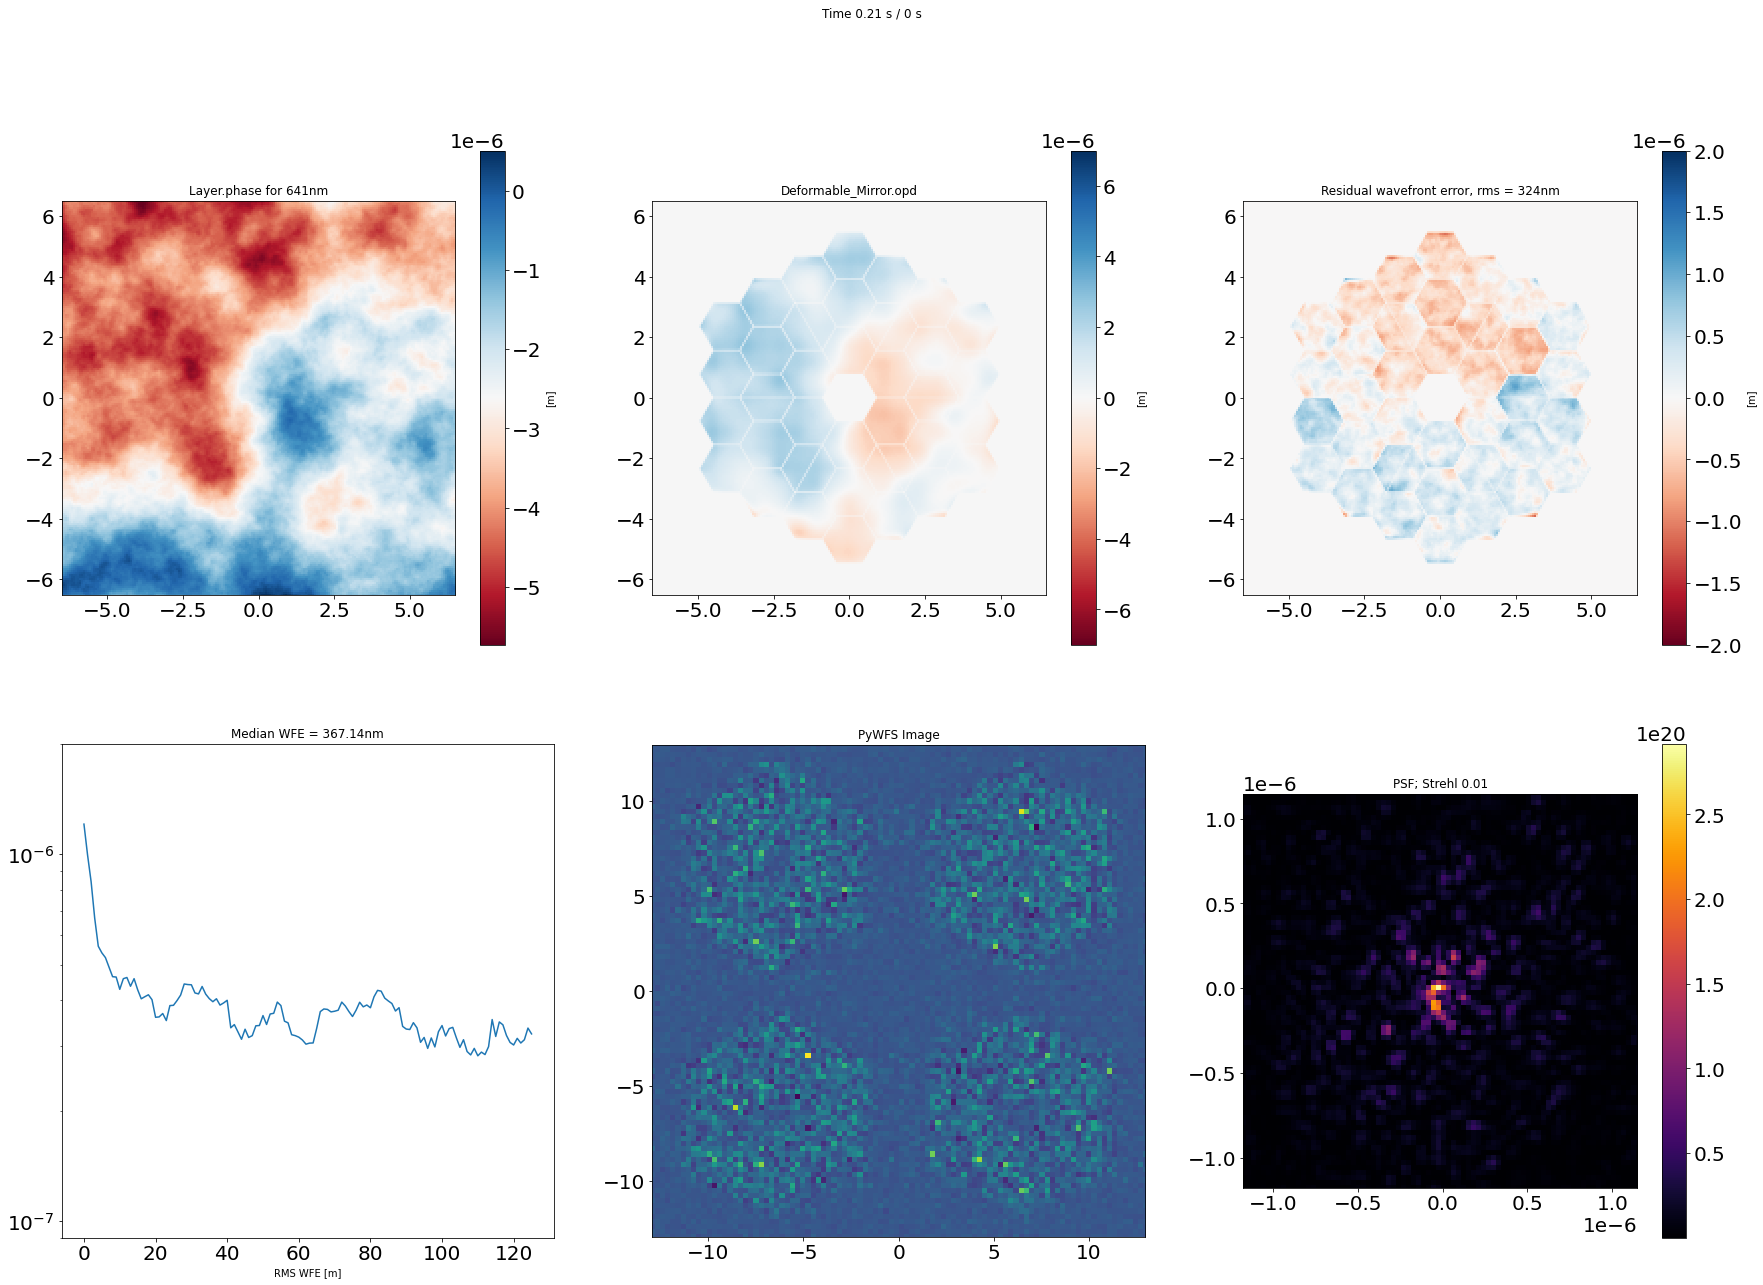

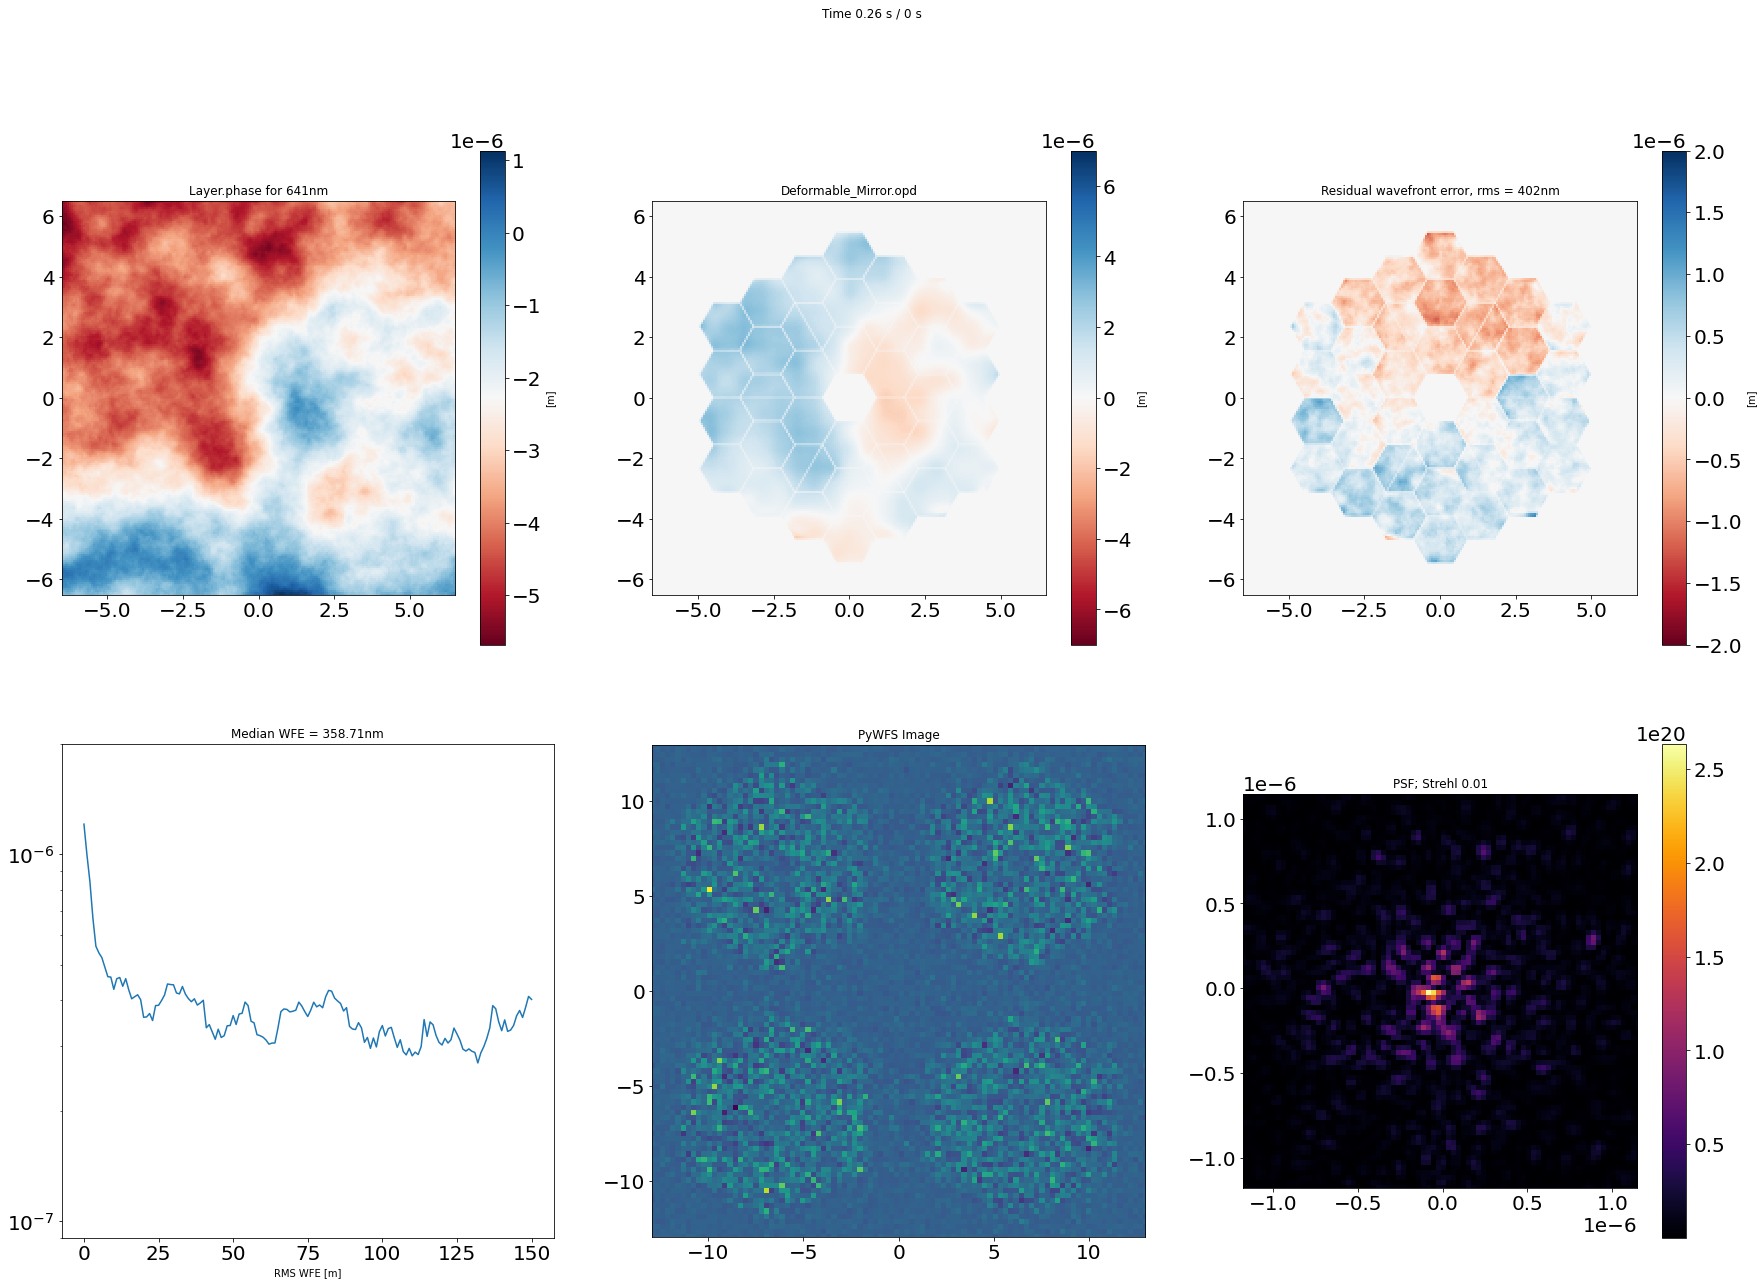

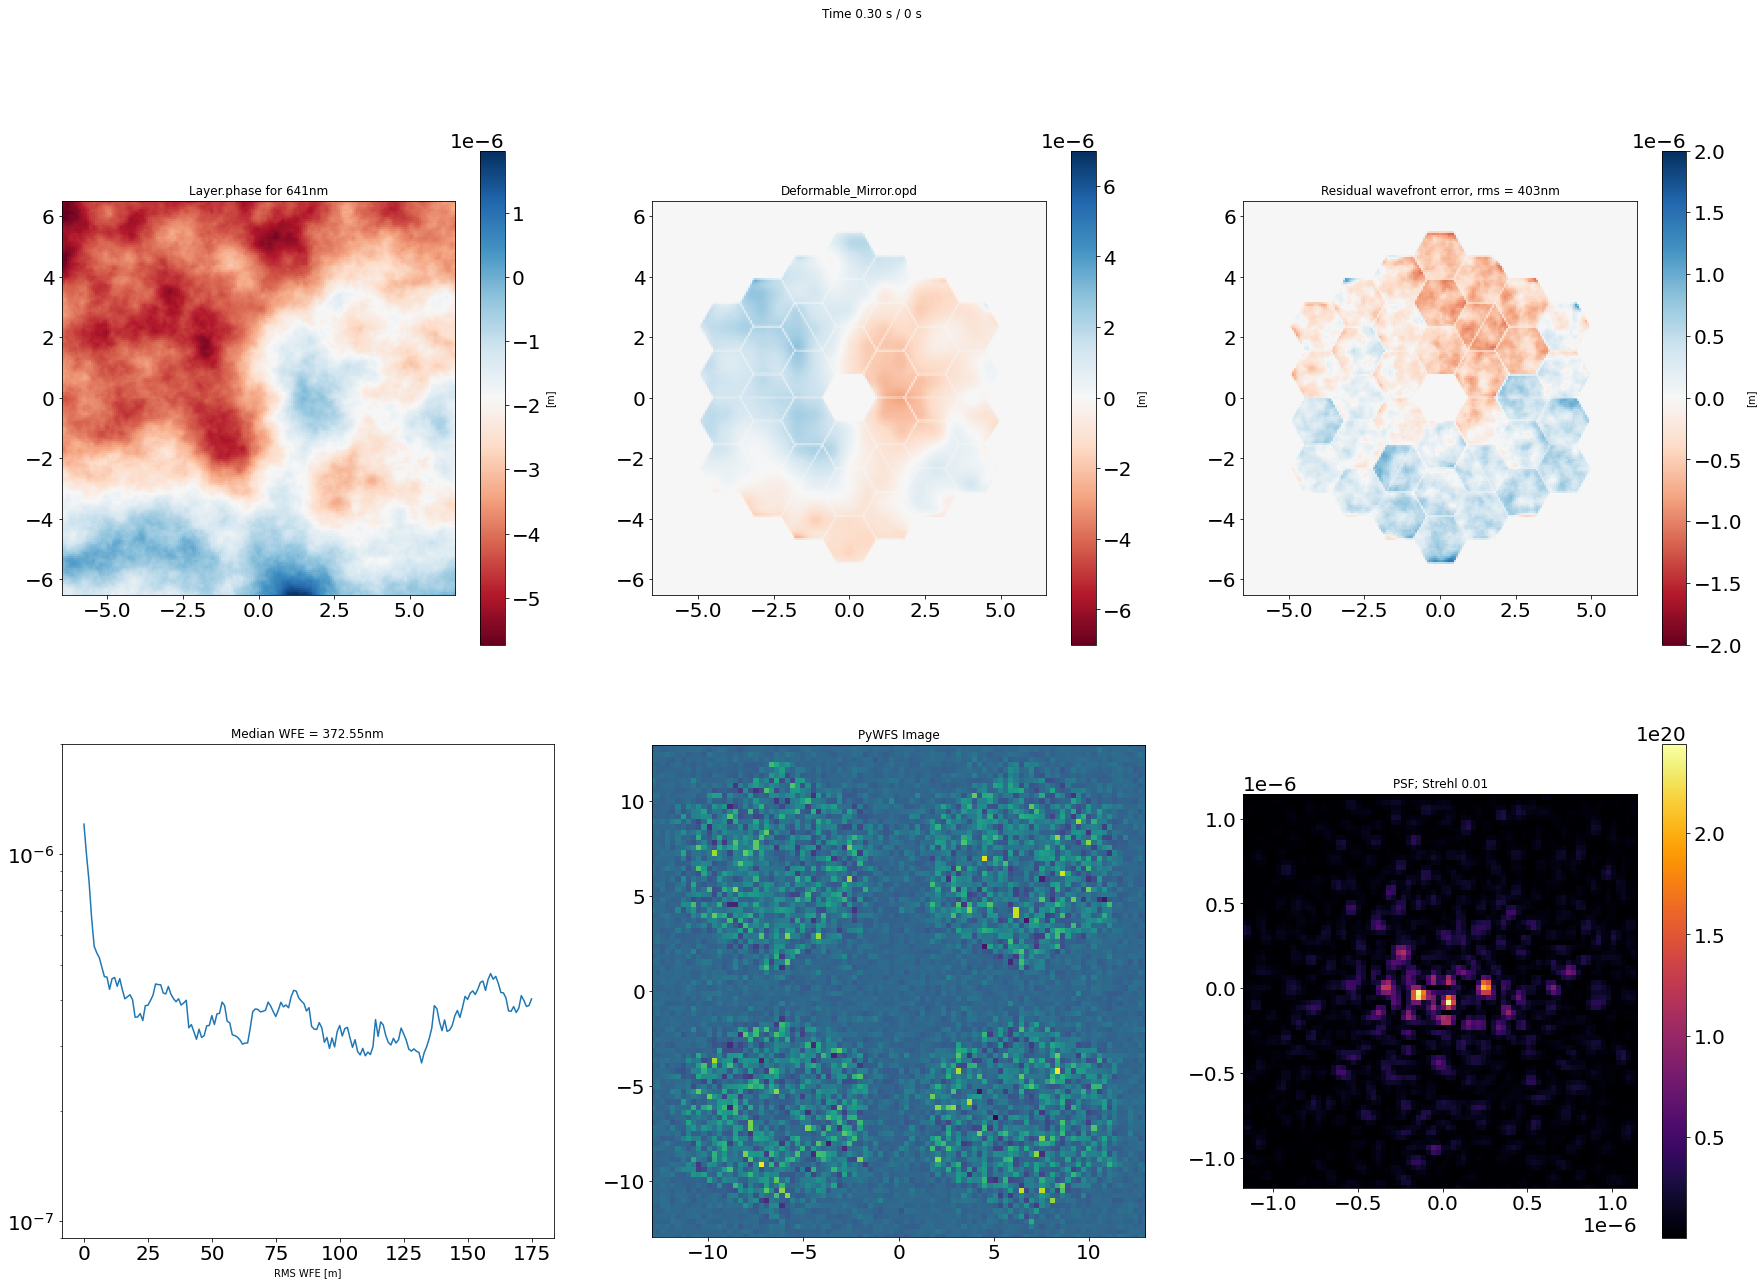

Time Elapsed =  59.412172029999965


In [49]:
plot_every = 25
num_iterations = exposure_total #number of iterations in our simulation
sr=[] # so we can find the average strehl ratio

# create figure
fig,axes=plt.subplots(2,3,figsize=(28,8))
# generate animation object; two optional backends FFMpeg or GifWriter. 
#anim = FFMpegWriter('AO_simulations_standard.mp4', framerate=3)
anim = GifWriter('AO_simulations_standard.gif', framerate=3)

#Set the layer to t=0
layer.t = 0

#Flatten the mirrors
deformable_mirror.flatten()

#Empty Lists of things we want to keep track of
AO_res=[]
rms = []
dm_opd = []

start = time.perf_counter()

for timestep in range(num_iterations): 
    
    #set tick labels font size for both axes
#     plt.tick_params(axis='both', which='major', labelsize=40)
    
    print("Percent complete = ", round((timestep+1)/num_iterations * 100, 3), end = '\r')

    #get a clean wavefront
    wf_in=wf.copy()
    wfs_wf_in=wfs_wf.copy()

    #evolve the atmospheric turbulence
    layer.t += dt
    
    #pass the wavefront through the turbulence
    wf_after_atmos = layer.forward((wf_in))
    wfs_wf_after_atmos = layer.forward((wfs_wf_in))
    
    #Pass the wavefront trough the primary
    wf_after_primary = primary.forward(wf_after_atmos)
    wfs_wf_after_primary = primary.forward(wfs_wf_after_atmos)
    
    #pass the wavefront through the DM for correction
    wf_after_dm = deformable_mirror.forward(wf_after_primary)
    wfs_wf_after_dm = deformable_mirror.forward(wfs_wf_after_primary)

    #send the wavefront containing the residual wavefront error to the PyWFS and get slopes
    wfs_wf_mpwfs = mpwfs.forward(wfs_wf_after_dm)
    for mmm in range (modsteps) :
              wfs_camera.integrate(wfs_wf_mpwfs[mmm], dt/modsteps)
    wfs_image = wfs_camera.read_out()   
    slopes = (wfs_image/wfs_image.sum()).flatten()-image_ref
    slopes = slopes.ravel()
    
    #Get the wfs_residuals
    dm_before = deformable_mirror.opd
    res=layer.phase_for(wavelength)/k+primary.opd+deformable_mirror.opd #units:meters; use this to save to avoid phase wrapping that is in the electric field of wf
    mn_res = np.mean(res[np.where(np.array(telescope_aperture))])
    res = res-mn_res
    res2=wf_after_dm.phase/k

    #Leaky integrator to calculate new DM commands    
    deformable_mirror.actuators =  leakage*deformable_mirror.actuators - gain * reconstruction_matrix.dot(slopes)
    
    #Save the residuals
    image_hdu = fits.ImageHDU(res*telescope_aperture)
#     hdul.append(image_hdu)
    #Keep track of the dm opds
    dm_opd.append(deformable_mirror.opd)
    
    #Calculate the rms residuals
    good_res = image_hdu.data[np.where(np.array(telescope_aperture))]
    good_res_mn = good_res - np.mean(good_res)
    rms.append(float((np.sqrt(np.mean(good_res_mn**2)))))

    # Propagate to focal plane
    propagator = prop
    wf_focal = propagator.forward(wf_after_dm )
    
    #calculate the strehl ratio to use as a metric for how well the AO system is performing. 
    strehl_foc=get_strehl_from_focal(wf_focal.intensity/norm,im_ref.intensity/norm)
    sr.append(strehl_foc)
    #plot the results                
    if timestep % plot_every == 0: #change this if you want to have more or less frames saved to the image. 
        plt.close(fig)
        fig,axes=plt.subplots(2,3,figsize=(30,20))
        axes = axes.flatten()
        plt.suptitle('Time %.2f s / %d s' % (timestep*dt, dt*num_iterations))

        
        axes[0].set_title("Layer.phase for {:.0f}nm".format(wavelength/1e-9))
        imshow_field(layer.phase_for(wavelength)/k, cmap = 'RdBu', ax=axes[0])
        cbar = plt.colorbar(label="[m]",ax=axes[0])
        cbar.formatter.set_powerlimits((0, 0))
        
                
        axes[1].set_title("Deformable_Mirror.opd")
        imshow_field(telescope_aperture*dm_before, cmap = 'RdBu', vmin = -7e-6, vmax = 7e-6,ax=axes[1])
        cbar = plt.colorbar(label="[m]",ax=axes[1])
        cbar.formatter.set_powerlimits((0, 0))

    
        axes[2].set_title('Residual wavefront error, rms = {:.0f}nm'.format(rms[-1]/1e-9))
        imshow_field(res*telescope_aperture-np.mean(good_res), ax=axes[2],cmap='RdBu', vmin = -2e-6, vmax = 2e-6)
        cbar = plt.colorbar(label="[m]",ax=axes[2])
        cbar.formatter.set_powerlimits((0, 0))
        

        axes[3].set_title('Median WFE = {:.2f}nm'.format(np.median(rms)/1e-9))
        axes[3].semilogy(rms)
        axes[3].set_xlabel("Frame Number")
        axes[3].set_xlabel("RMS WFE [m]")
        axes[3].set_ylim(9e-8,2e-6)
        
        
        axes[4].set_title("PyWFS Image")
        imshow_field(wfs_image,ax=axes[4])
        
        axes[5].set_title('PSF; Strehl %.2f'% (np.mean(np.asarray(sr))))
#         imshow_field(np.log10(wf_focal.intensity/norm), cmap='inferno',ax=axes[5])
        imshow_field(wf_focal.intensity, cmap='inferno',ax=axes[5])
        plt.colorbar(ax=axes[5])
        
        plt.show()

        
#plt.suptitle('Gain = %.2f' % (gain)) # can change this to be the parameter you are varying
#plt.savefig('AO_vary_gain%.2f.png' % (gain)) #example to save the last figure to see how the parameter varied your performance

plt.close()
# anim.close()
# anim
stop = time.perf_counter()
print("Time Elapsed = ", stop-start)

# plt.plot(np.array(sr))
# plt.show()